<h1> Group 38 Project Report </h1>

<h1> The Epidemiology of Country HDI and Tuberculosis Mortality <h1>
    
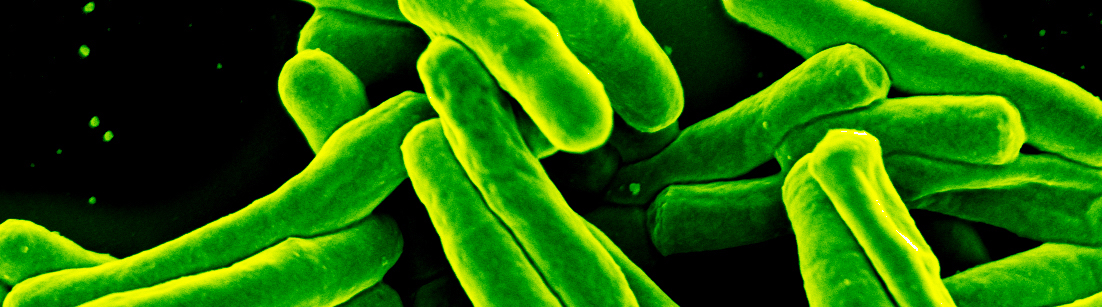
    
    
<font size="2"> <i>image attribution</i>: NIAID Mycobacterium tuberculosis Bacteria, the Cause of TB, CC BY 2.0 <https://creativecommons.org/licenses/by/4.0>, via Flickr at <https://www.flickr.com/photos/niaid/51637606937/in/photostream/> </font>

<h3>Introduction</h3>
<hr>

*Total Word Count:* ...

Mycobacterium tuberculosis (TB) is the bacterium responsible for tuberculosis, a contagious respiratory pathogen that  targets lung tissue. TB spreads through depositions on airborne aerosol droplets, and may stay latent for long periods until emerging (CDC, 2020). Currently, TB is responsible for 2 million deaths each year, and is one of the most common infections worldwide (Smith, 1). As an opportunistic disease, TB often complicates the effects of other pathogens, making it much more difficult to study. 

For patients with the HIV virus, particularly those with AIDS (CD4 cell count below 200 cells/mm<sup>3</sup>), co-infection by opportunistic TB is much more dangerous, “increas[ing] the risk of latent TB reactivation 20-fold” (Sofia et al, 1)(Pawlowski et al, 1). Outbreaks in HIV have also been associated with co-outbreaks of TB, and the HIV TB co-epidemics are a current source of ongoing research. Understanding how TB spreads and what factors affect its virulence is thus of vital importance for the both the scientific, and HIV community worldwide.


The effect of socioeconomic factors and country development on TB spread is a currently understudied area of epidemiological literature (Rodríguez-Morales, e704). For this investigation, we therefore consider the effect of the United Nations Human Development Index (HDI) upon TB morbidity worldwide.

Of the current studies in this area, most agree that as HDI increases, TB mortality decreases - marking our null hypothesis. The purpose of our study will then be to assess this claim via hypothesis testing, considering TB mortality in high and low HDI countries.

<h3>Methods and Results</h3>
<hr>

In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra, warn.conflicts=FALSE)
library(readxl)
options(repr.matrix.max.rows = 6)
options(repr.matrix.max.cols = 3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


For this investigation, we use two datasets: the **World Health Organization (WHO)** TB dataset, and the **United Nations Development Reports (UNDP)** HDI dataset.

In [2]:
# URL of the WHO dataset csv file
tb_url <- "https://apps.who.int/gho/athena/data/xmart.csv?target=GHO/MDG_0000000017,TB_e_mort_exc_tbhiv_num&profile=crosstable&filter=COUNTRY:*;REGION:*&ead=&x-sideaxis=COUNTRY;YEAR&x-topaxis=GHO"
# Reading this csv file into a dataframe
tb_df <- read.csv(tb_url)

head(tb_df)

,Country,Year,⋯,Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.
,<chr>,<int>,⋯,<chr>
1,Afghanistan,2021,⋯,31 [18-47]
2,Afghanistan,2020,⋯,34 [20-52]
3,Afghanistan,2019,⋯,26 [15-39]
4,Afghanistan,2018,⋯,29 [17-44]
5,Afghanistan,2017,⋯,30 [18-45]
6,Afghanistan,2016,⋯,34 [20-51]


First, we'll wrangle the **WHO** dataset into tidy format before incorporating the **UNDP** HDI data, using 2020 as our year to reflect the current TB trends.

In [3]:
#Rename the data columns so we can easily work with them 
tb_df <- tb_df %>%
    # Selecting the columns of interest
    select(Country, Year, Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.) %>%
    # Renaming columns to improve readability 
    rename(Deaths_due_to_TB_per_100_000 = Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.) %>%
    # Setting the year to 2020
    filter(Year == 2020) %>%
    # Removing the Year column now that 2020 has been selected
    select(-Year)

We use REGEX and the str_remove function to remove error bars, converting the type of mortality to double

In [4]:
tb_df <- tb_df %>%
    # Removing all error bars with " \\[.*\\]" in regex, and all spaces with str_remove_all(..., " ")
    mutate(Deaths_due_to_TB_per_100_000 = str_remove_all(str_remove(Deaths_due_to_TB_per_100_000, " \\[.*\\]"), " ")) %>%
    # Converting the column to be of type double
    mutate(Deaths_due_to_TB_per_100_000 = as.double(Deaths_due_to_TB_per_100_000)) %>%
    # NA values removed for safety
    filter(!is.na(Deaths_due_to_TB_per_100_000))
tb_df

Country,Deaths_due_to_TB_per_100_000
<chr>,<dbl>
Afghanistan,34.00
Albania,0.32
Algeria,9.00
⋮,⋮
Yemen,9.5
Zambia,32.0
Zimbabwe,12.0


Following the classification of the UNDP, we consider a high HDI to be values >0.700, and low to be HDI values <0.550

In [5]:
# Now, we import the HDI csv file

# URL of the UNDP HDI Dataset
hdi_url <- "https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Statistical_Annex_HDI_Trends_Table.xlsx"
# We download this dataset first as read_excel works with local files
download.file(hdi_url, destfile = "HDI_Global_Database.xlsx") 

# SuppressMessages used here to prevent read_excel from printing every column in sets to a default name 
suppressMessages(
hdi_df <- read_excel("HDI_Global_Database.xlsx", sheet = 1, col_names = TRUE))

# Make.names removes the spaces from the column names 
names(hdi_df) = make.names(names(hdi_df))

hdi_df <- hdi_df %>%
    #Here we select the two columns of interest
    select("Table.2..Human.Development.Index.trends..1990.2021", "...15") %>%
    #To make them easier to work with, we rename them to Country and HDI
    rename("Country" = "Table.2..Human.Development.Index.trends..1990.2021" , "HDI" = "...15") %>%
    #Turning the type of HDI from <chr> to <dbl>
    mutate(HDI = as.double(HDI)) %>%
    #Removing NA values
    filter(!is.na(HDI))
    
# Because this data formats poorly (due to spacings added for visual aesthetic in the .xlsx file), 
# we remove non-relevant data rows here to fix this issue
hdi_df = hdi_df[-c(1, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210),]
hdi_df

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Country,HDI
<chr>,<dbl>
Switzerland,0.956
Norway,0.959
Iceland,0.957
⋮,⋮
Niger,0.401
Chad,0.397
South Sudan,0.386


The HDI and TB databases use different country names, however, which we'll need to standardize.

To get a picture of which names differ, we call R's setdiff function on the two country columns

In [6]:
# Returns the differences between the countries in the tuberculosis dataframe, and the HDI dataframe.
# Countries printed below are those which are present in the tuberculosis data, but not in the HDI data due to name
# mismatch or their data not being present (i.e Cook Islands)
setdiff(tb_df$Country, hdi_df$Country)

[1] "Cook Islands"                                        
 [2] "Democratic Republic of the Congo"                    
 [3] "Eswatini"                                            
 [4] "Monaco"                                              
 [5] "Nauru"                                               
 [6] "Niue"                                                
 [7] "Republic of Korea"                                   
 [8] "Republic of Moldova"                                 
 [9] "Somalia"                                             
[10] "United Kingdom of Great Britain and Northern Ireland"
[11] "United Republic of Tanzania"                         
[12] "United States of America"

We use case_when to standardize these names. Countries unaccounted are those for which HDI data is not available.

In [7]:
hdi_df <- hdi_df %>%
    mutate(Country = case_when(Country == "Congo (Democratic Republic of the)" ~ "Democratic Republic of the Congo",
                                  Country == "Eswatini (Kingdom of)" ~ "Eswatini",
                                  Country == "Korea (Republic of)" ~ "Republic of Korea",
                                  Country == "Moldova (Republic of)" ~ "Republic of Moldova",
                                  Country == "United Kingdom" ~ "United Kingdom of Great Britain and Northern Ireland",
                                  Country == "Tanzania (United Republic of)" ~ "United Republic of Tanzania",
                                  Country == "United States" ~ "United States of America",
                                  TRUE ~ Country)) # Our else case

We now merge the two datasets and catagorize HDI accordingly

In [8]:
tb_hdi_df <- tb_df %>%
    # merging of the two datasets, all,x = FALSE removes countries present in one dataset but not the other
    merge(hdi_df,by = "Country", all.x = FALSE) %>%
    # Only taking HDI values classified as low or high
    filter(HDI > 0.700 | HDI < 0.550) %>%
    # Discretizing the HDI data into Low and High values
    mutate(HDI = ifelse(HDI > 0.700, "High", "Low")) %>%
    # Changing HDI column name to reflect categorization
    rename("HDI_Classification" = "HDI")
 

tb_hdi_df

Country,Deaths_due_to_TB_per_100_000,HDI_Classification
<chr>,<dbl>,<chr>
Afghanistan,34.00,Low
Albania,0.32,High
Algeria,9.00,High
⋮,⋮,⋮
Uzbekistan,3.2,High
Viet Nam,8.9,High
Yemen,9.5,Low


We compare these two distributions subsequently with a boxplot

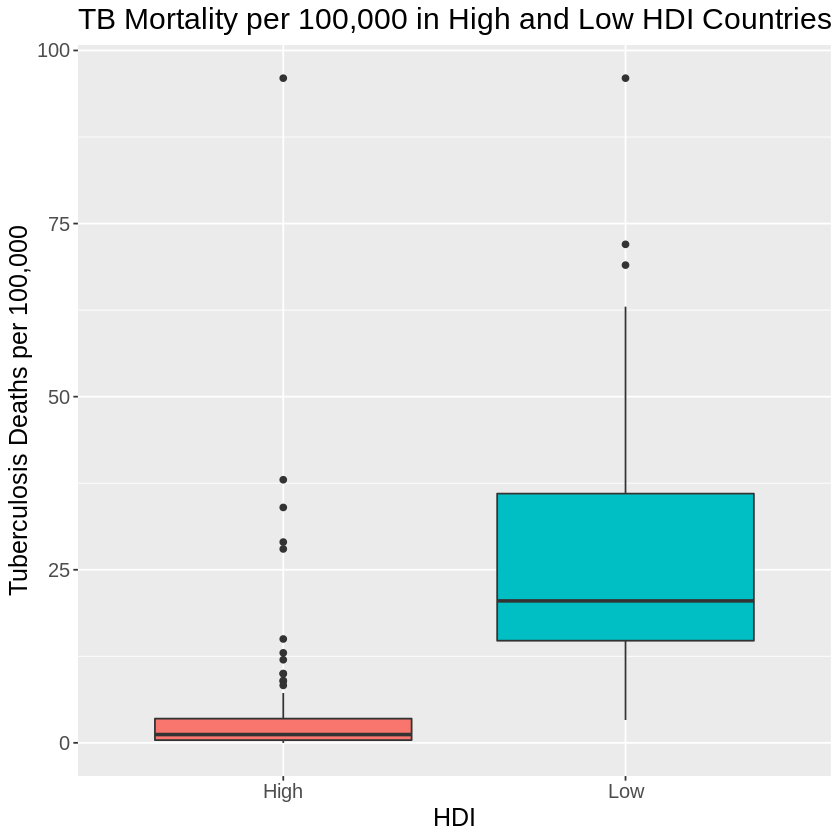

In [9]:
hdi_tb_boxplot <- tb_hdi_df %>% 
    ggplot(aes(x = HDI_Classification, y = Deaths_due_to_TB_per_100_000, fill = HDI_Classification)) +
    geom_boxplot() +
    theme(text = element_text(size = 15)) +
    ggtitle("TB Mortality per 100,000 in High and Low HDI Countries") + 
    xlab("HDI") + 
    ylab("Tuberculosis Deaths per 100,000") + 
    guides(fill = "none")

show(hdi_tb_boxplot)

Our parameters are shown below

In [10]:
options(repr.matrix.max.cols = 4)
tb_hdi_table <- tb_hdi_df %>%
    group_by(HDI_Classification) %>%
    summarize(Mean = mean(Deaths_due_to_TB_per_100_000),
              Variance = var(Deaths_due_to_TB_per_100_000),
              Population_Size = n())

tb_hdi_table

HDI_Classification,Mean,Variance,Population_Size
<chr>,<dbl>,<dbl>,<int>
High,4.133772,114.9204,114
Low,28.800000,496.6948,32


From the visualisation above, we see that the mean TB deaths in low HDI countries is significantly higher than in high HDI countries, which seems to support the current epidemiological consensus. It is interesting, however, that the low income standard deviation is much larger (22.3) than the high income (10.72), perhaps due to TB epidemics in some, but not all low HDI countries, generating increased variation. We plan on discussing this further below.

We now move on to the hypothesis testing portion of this report

<h4> Hypothesis Testing with Cumulative Limit Theorem (CLT)</h4>
<hr>

In this investigation, we will be using both asymptotics and bootstrapping to calculate the p-value of our hypothesis tests, following the following null and alternative hypotheses:

- **Null**: Tuberculosis mortality in low HDI countries is greater or equal to those in high HDI countries.
    - $\mu_l - \mu_h \geq 0$
- **Alternate**: Tuberculosis mortality in low HDI countries is less than mortality in high HDI countries.
    - $\mu_l - \mu_h < 0$

where $\mu_l$ is mean mortality in low HDI countries, and $\mu_l$ is mean mortality in high HDI countries. Our parameters of interest are defined below.

We will begin with a two-sample t-test, which we have chosen given an approximation of the true standard deviation. We will assume here that our two populations are normally distributed, though this will be considered in our analysis section.

We calculate our test statistic $T$ and degrees of freedom $\nu$ using the below formulas, which are handled with R's in build t.test function

<h4> $T = \frac{\bar{x} - \bar{y}}{\sqrt{\frac{s^2_1} {n_1} + \frac{s^2_2}{n_2}}}$&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp$\nu = \frac{(\frac{s^2_1} {n_1} + \frac{s^2_2}{n_2})^2}{\frac{s^4_1}{n^2_1(n_1 - 1)}+\frac{s^4_2}{n^2_2(n_2 - 1)}}$ </h4>

In [27]:
options(repr.matrix.max.cols = 10)

low_hdi <- tb_hdi_df %>%
    filter(HDI_Classification == "Low") %>%
    select(Deaths_due_to_TB_per_100_000)
high_hdi <- tb_hdi_df %>%
    filter(HDI_Classification == "High") %>%
    select(Deaths_due_to_TB_per_100_000)

t_test <- 
    tidy(
        t.test(x = low_hdi,
               y = high_hdi,
               alternative = "less"),
               conf.level = 0.95) 
               #Specifying a confidence of 95% for our interval
    

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
24.66623,28.8,4.133772,6.066932,0.9999997,35.11678,-Inf,31.53488,Welch Two Sample t-test,less


We can thus be 95% confident that the true value of $\mu_l - \mu_h$ resides somewhere in the range $-\infty \leq \mu_l - \mu_h \leq 31.53$. 

We can thus strongly reject the alternative hypothesis with p value 0.9999997, demonstrating through t-testing and the CLT that countries with higher HDI have lower TB mortality.

<h4> Hypothesis Testing with Bootstrapping</h4>
<hr>

Bootstrapping is another powerful technique when hypothesis testing and calculating confidence intervals. We perform bootstrapping here using the infer package.

In [38]:
bootstrap_ci <- tb_hdi_df %>%
    select(HDI_Classification, Deaths_due_to_TB_per_100_000) %>%
    specify(response = Deaths_due_to_TB_per_100_000) %>%
    generate(reps = 5000, type = "bootstrap") %>%
    calculate(stat = "mean") %>%
    get_confidence_interval(level = 0.95, type = "percentile")


bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
6.971298,12.49236


<h4> Analysis of Results </h4>
<hr>

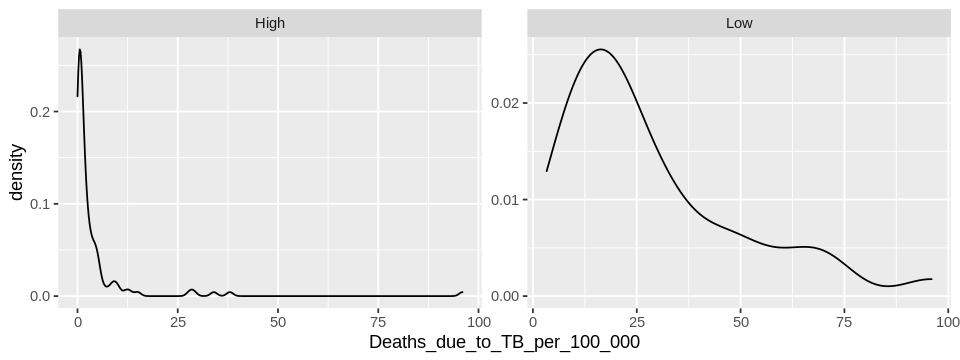

In [40]:
options(repr.plot.width = 8, repr.plot.height = 3)


hdi_tb_boxplot <- tb_hdi_df %>%
    ggplot(aes(x = Deaths_due_to_TB_per_100_000)) +
    geom_density() + 
    facet_wrap(vars(HDI_Classification), scales = "free")

hdi_tb_boxplot

<h3>Citations</h3>
<hr>

Centers for Disease Control and Prevention. (2011, October 28). Fact sheets. Centers for Disease Control and Prevention. Retrieved March 18, 2023, from https://www.cdc.gov/tb/publications/factsheets/general/tb.htm#:~:text=Tuberculosis%20(TB)%20is%20a%20disease,they%20do%20not%20get%20treatment 

Centers for Disease Control and Prevention. (2016, March 15). TB and HIV Coinfection. Centers for Disease Control and Prevention. Retrieved March 18, 2023, from https://www.cdc.gov/tb/topic/basics/tbhivcoinfection.htm 

Centers for Disease Control and Prevention. (2022, June 30). About HIV/AIDS. Centers for Disease Control and Prevention. Retrieved March 18, 2023, from https://www.cdc.gov/hiv/basics/whatishiv.html#:~:text=What%20is%20HIV%3F,they%20have%20it%20for%20life 

Nations, U. (2023, January 23). Human development index. Human Development Reports. Retrieved March 18, 2023, from https://hdr.undp.org/data-center/human-development-index#/indicies/HDI 

Niaid. (2021, October 29). Mycobacterium tuberculosis bacteria, the cause of TB. Flickr. Retrieved March 18, 2023, from https://www.flickr.com/photos/niaid/51637606937/in/photostream/ 

Smith, I. (2003, July 1). Mycobacterium tuberculosis Pathogenesis and Molecular Determinants of Virulence. Clinical Microbiology Reviews. Retrieved March 18, 2023, from https://journals.asm.org/doi/abs/10.1128/cmr.16.3.463-496.2003?maxtoshow=H16%2F3%2F463r16%2F3%2F463 

World Health Organization. (2022, October 11). Gho | by category | mortality - data by WHO region. World Health Organization. Retrieved March 18, 2023, from https://apps.who.int/gho/data/view.main.57016ALL?lang=en

Garcia, S. A. B., & Guzman, N. (2021). Acquired Immune Deficiency Syndrome CD4+ Count. In StatPearls [Internet]. StatPearls Publishing.

Rodríguez-Morales, A. J., & Castañeda-Hernández, D. M. (2012). Relationships between morbidity and mortality from tuberculosis and the human development index (HDI) in Venezuela, 1998–2008. International Journal of Infectious Diseases, 16(9), e704-e705.